### Working Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks
!ls

/content/drive/MyDrive/Colab Notebooks
amazon_alexa.tsv  SentimentAnalysis_wellbe.ipynb


### Import Dataset

In [3]:
import pandas as pd

data = pd.read_csv('amazon_alexa.tsv', sep='\t')
data.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [4]:
mydata = data[['verified_reviews','feedback']]
mydata.columns = ['review','label']

mydata.head()

,review,label
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [5]:
mydata.value_counts('label')

label
1    2893
0     257
Name: count, dtype: int64

In [6]:
# Count the occurrences of each label
label_counts = mydata["label"].value_counts()

# Get the number of rows to drop from the majority class
rows_to_drop = label_counts.max() - label_counts.min()

# Drop rows from the majority class randomly
if rows_to_drop > 0:
   data_majority = mydata[mydata["label"] == 1]
   data_balanced = mydata.drop(data_majority.sample(rows_to_drop).index)
else:
   data_balanced = mydata.copy()

# Check the new class balance
print(data_balanced["label"].value_counts())

label
1    257
0    257
Name: count, dtype: int64


## Data Preprocessing

In [7]:
import re

def clean_text(text):
  # Remove special characters and punctuation
  text = re.sub(r"[^\w\s]", " ", text)

  # Remove single characters
  text = re.sub(r"\b[a-zA-Z]\b", " ", text)

  # Remove HTML tags
  text = re.sub(r"<[^>]*>", " ", text)

  # Lowercase the text
  text = text.lower()

  # Remove extra whitespace
  text = re.sub(r"\s+", " ", text)

  # Trim leading and trailing spaces
  text = text.strip()

  return text

In [10]:
import pandas as pd

# Make sure the data inthe column are strings
data_balanced['review']=data_balanced['review'].apply(str)

# Extract the review column as a list
reviews = data_balanced['review'].tolist()


# Clean the text in the list
cleaned_reviews = [clean_text(review) for review in reviews]

# Add the cleaned reviews as a new column to the DataFrame
data_balanced['clean_reviews'] = cleaned_reviews

In [11]:
data_balanced

,review,label,clean_reviews
6,"Without having a cellphone, I cannot use many ...",1,without having cellphone cannot use many of he...
7,I think this is the 5th one I've purchased. I'...,1,think this is the 5th one ve purchased working...
22,Have only had it set up for a few days. Still ...,1,have only had it set up for few days still add...
26,"I love my Echo. It's easy to operate, loads of...",1,love my echo it easy to operate loads of fun i...
27,Sounds great!! Love them!,1,sounds great love them
...,...,...,...
3097,I have a friend now.,1,have friend now
3099,Good device,1,good device
3124,Love my Alexa! Actually have 3 throughout the ...,1,love my alexa actually have 3 throughout the h...
3129,We have six of these throughout our home and t...,1,we have six of these throughout our home and t...


## Data Split

In [12]:
import pandas as pd

# Assuming your DataFrame is called "df"
total_rows = len(data_balanced)
test_size = int(total_rows * 0.95)

# Randomly sample train_size rows for the training set
test_set = data_balanced.sample(test_size)

# Get the remaining rows for the test set
train_set = data_balanced.drop(test_set.index)

## Sentiment w/ LLM

### Setting up Gemini API

In [13]:
!pip install -q -U google-generativeai

In [14]:
# Necessary packages
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

# Used to securely store your API key
from google.colab import userdata

In [15]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [16]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [17]:
model = genai.GenerativeModel('gemini-pro')

In [18]:
%%time
response = model.generate_content("What is the meaning of life?")

to_markdown(response.text)

CPU times: user 90.8 ms, sys: 12 ms, total: 103 ms
Wall time: 5.92 s


> The meaning of life is a question that has been pondered by philosophers, theologians, and scientists for millennia. There is no one definitive answer, and the meaning of life may be different for different people. Some common answers to the question include:
> 
> * **To find happiness and fulfillment**
> * **To make a difference in the world**
> * **To connect with others**
> * **To learn and grow**
> * **To serve a higher purpose**
> 
> Ultimately, the meaning of life is something that each individual must determine for themselves. There is no right or wrong answer, and the search for meaning can be a lifelong journey.
> 
> Here are some additional thoughts on the meaning of life:
> 
> * **The meaning of life is not static**. It can change as we grow and change throughout our lives.
> * **The meaning of life is not something that is found**. It is something that is created.
> * **The meaning of life is not something that is given to us**. It is something that we must find for ourselves.
> 
> The search for meaning can be a difficult and challenging one. However, it is a worthwhile one. Finding meaning in our lives can lead to greater happiness, fulfillment, and purpose.

#### Single API Call

In [19]:
test_set_sample = test_set.sample(20)

## Creating a new column for prediction generative model
test_set_sample['pred_label'] = ''

test_set_sample

,review,label,clean_reviews,pred_label
526,Not good at all!,0,not good at all,
2784,I loved it does exactly what it says,1,loved it does exactly what it says,
836,Not much features.,0,not much features,
324,We really only use this as a speaker to stream...,1,we really only use this as speaker to stream m...,
484,"A small problem out of the box, but a rep from...",1,small problem out of the box but rep from amaz...,
2177,I already bought one previously to try out and...,1,already bought one previously to try out and e...,
2687,Perfect for a home office,1,perfect for home office,
1425,Needs to play YouTube and prime video and mayb...,1,needs to play youtube and prime video and mayb...,
1935,wish it had a battery or was described better ...,0,wish it had battery or was described better as...,
1903,Terrible. Stopped working after one day.,0,terrible stopped working after one day,


In [20]:
# Convert the DataFrame to JSON using the to_json() method

json_data = test_set_sample[['clean_reviews','pred_label']].to_json(orient='records')

# Print the JSON data
print(json_data)

[{"clean_reviews":"not good at all","pred_label":""},{"clean_reviews":"loved it does exactly what it says","pred_label":""},{"clean_reviews":"not much features","pred_label":""},{"clean_reviews":"we really only use this as speaker to stream music we ve had it 7 months and it just kinda useless","pred_label":""},{"clean_reviews":"small problem out of the box but rep from amazon called and walked me through reset process which solved my issues was shocked to get response so quickly and real effort was made including follow up email to get this thing working have 6 now and one google clone and the more use it and learn about it the more like it them also plan to install one in my car boat and garage alexa is my new best friend lol think gf is worried that if alexa learns to cook her time will be limited","pred_label":""},{"clean_reviews":"already bought one previously to try out and enjoyed it bought these new ones during the prime sale","pred_label":""},{"clean_reviews":"perfect for home

In [21]:
prompt = f"""
You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
Customer reviews are provided between three back ticks.
In your output, only return the Json code back as output - which is provided between three backticks.
Your task is to update predicted labels under 'pred_label' in the Json code.
Don't make any changes to Json code format, please.

```
{json_data}
```
"""

print(prompt)


You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
Customer reviews are provided between three back ticks.
In your output, only return the Json code back as output - which is provided between three backticks.
Your task is to update predicted labels under 'pred_label' in the Json code.
Don't make any changes to Json code format, please.

```
[{"clean_reviews":"not good at all","pred_label":""},{"clean_reviews":"loved it does exactly what it says","pred_label":""},{"clean_reviews":"not much features","pred_label":""},{"clean_reviews":"we really only use this as speaker to stream music we ve had it 7 months and it just kinda useless","pred_label":""},{"clean_reviews":"small problem out of the box but rep from amazon called and walked me through reset process which solved my issues was shocked to get response so quickly and real effort was made in

In [22]:
response = model.generate_content(prompt)

print(response.text)

```
[{"clean_reviews":"not good at all","pred_label":0},{"clean_reviews":"loved it does exactly what it says","pred_label":1},{"clean_reviews":"not much features","pred_label":0},{"clean_reviews":"we really only use this as speaker to stream music we ve had it 7 months and it just kinda useless","pred_label":0},{"clean_reviews":"small problem out of the box but rep from amazon called and walked me through reset process which solved my issues was shocked to get response so quickly and real effort was made including follow up email to get this thing working have 6 now and one google clone and the more use it and learn about it the more like it them also plan to install one in my car boat and garage alexa is my new best friend lol think gf is worried that if alexa learns to cook her time will be limited","pred_label":1},{"clean_reviews":"already bought one previously to try out and enjoyed it bought these new ones during the prime sale","pred_label":1},{"clean_reviews":"perfect for home o

In [23]:
import json

# Clean the data by stripping the backticks
json_data = response.text.strip("`")

# Load the cleaned data and convert to DataFrame
data = json.loads(json_data)
df_sample = pd.DataFrame(data)

df_sample

,clean_reviews,pred_label
0,not good at all,0
1,loved it does exactly what it says,1
2,not much features,0
3,we really only use this as speaker to stream m...,0
4,small problem out of the box but rep from amaz...,1
5,already bought one previously to try out and e...,1
6,perfect for home office,1
7,needs to play youtube and prime video and mayb...,0
8,wish it had battery or was described better as...,0
9,terrible stopped working after one day,0


In [24]:
# prompt: Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_sample['pred_label'] = df_sample['pred_label'].values
test_set_sample

,review,label,clean_reviews,pred_label
526,Not good at all!,0,not good at all,0
2784,I loved it does exactly what it says,1,loved it does exactly what it says,1
836,Not much features.,0,not much features,0
324,We really only use this as a speaker to stream...,1,we really only use this as speaker to stream m...,0
484,"A small problem out of the box, but a rep from...",1,small problem out of the box but rep from amaz...,1
2177,I already bought one previously to try out and...,1,already bought one previously to try out and e...,1
2687,Perfect for a home office,1,perfect for home office,1
1425,Needs to play YouTube and prime video and mayb...,1,needs to play youtube and prime video and mayb...,0
1935,wish it had a battery or was described better ...,0,wish it had battery or was described better as...,0
1903,Terrible. Stopped working after one day.,0,terrible stopped working after one day,0


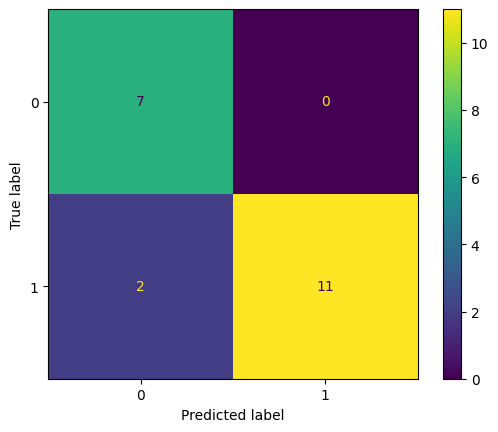

In [28]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_set_sample["label"]
y_pred = test_set_sample["pred_label"]

confusion_matrix(y_true, y_pred)

## For a better display
y_test = test_set_sample["label"]
predictions = test_set_sample["pred_label"]

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



### OpenAI API Config

In [ ]:
!pip install openai==0.27.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
import openai
from google.colab import userdata

OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
openai.api_key  = OPENAI_API_KEY

In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo-1106"):

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)

  return response.choices[0].message["content"]

In [ ]:
prompt = "Why is the sky blue?"

chatgpt_response = get_completion(prompt)

In [ ]:
chatgpt_response

"The sky appears blue to our eyes because of the way the Earth's atmosphere scatters sunlight. The molecules in the Earth's atmosphere, particularly nitrogen and oxygen, scatter shorter wavelengths of light (blue and violet) more effectively than longer wavelengths (red and yellow). This scattering causes the blue light to be more visible and gives the sky its blue color. This effect is known as Rayleigh scattering."

#### Batching API Calls (Single Shot)

In [ ]:
test_set.shape

(488, 3)

In [ ]:
test_set_total = test_set.sample(100)

test_set_total['pred_label'] = ''

test_set_total

,review,label,clean_reviews,pred_label
2786,Very convenient,1,very convenient,
1913,Excellent why didn’t I think it is in the begi...,1,excellent why didn think it is in the beginnin...,
2621,Love it,1,love it,
672,Bought this to go in my niece's room. You can'...,1,bought this to go in my niece room you can tel...,
2225,"The current demand for this stick, was too hig...",1,the current demand for this stick was too high...,
...,...,...,...,...
653,I wanted a white dot for my white bathroom. T...,0,wanted white dot for my white bathroom the top...,
857,"Stopped working after 2 weeks ,didn't follow c...",0,stopped working after 2 weeks didn follow comm...,
2005,Why do we need to buy a $100 hub to get it to ...,0,why do we need to buy 100 hub to get it to wor...,
1342,I am very excited and happy with this. It was ...,1,am very excited and happy with this it was bre...,


In [ ]:
batches = []
batch_size = 50

for i in range(0, len(test_set_total), batch_size):
  batches.append(test_set_total[i : i + batch_size])  # Append batches instead of assigning

In [ ]:
import time

def gpt_completion_function(batch,current_batch,total_batch,model="gpt-3.5-turbo-1106"):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing the Gemini Prompt
  # Step-3: Calling GPT API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_reviews','pred_label']].to_json(orient='records')

  prompt = f"""You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {json_data}
  ```
  """

  print(prompt)

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)
  time.sleep(5)
  return response.choices[0].message["content"]

In [ ]:
batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gpt_completion_function(batches[i],i,batch_count))

Now processing batch#: 1 of 2
You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  [{"clean_reviews":"very convenient","pred_label":""},{"clean_reviews":"excellent why didn think it is in the beginning love it","pred_label":""},{"clean_reviews":"love it","pred_label":""},{"clean_reviews":"bought this to go in my niece room you can tell it refurbished it looks good and works like new","pred_label":""},{"clean_

In [ ]:
import json

df_total = pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Append the DataFrame to the final DataFrame
  df_total = df_total.append(df_temp, ignore_index=True)

print(df_total)  # Display the final DataFrame

                                        clean_reviews  pred_label
0                                     very convenient           1
1   excellent why didn think it is in the beginnin...           1
2                                             love it           1
3   bought this to go in my niece room you can tel...           1
4   the current demand for this stick was too high...           0
..                                                ...         ...
95  wanted white dot for my white bathroom the top...           0
96  stopped working after 2 weeks didn follow comm...           0
97  why do we need to buy 100 hub to get it to wor...           0
98  am very excited and happy with this it was bre...           1
99  in one word amazing best tech purchase have ev...           1

[100 rows x 2 columns]


<ipython-input-34-6f10fdd72bc6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_temp, ignore_index=True)
<ipython-input-34-6f10fdd72bc6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_temp, ignore_index=True)


In [ ]:
# prompt: Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_total['pred_label'] = df_total['pred_label'].values
test_set_total

,review,label,clean_reviews,pred_label
2786,Very convenient,1,very convenient,1
1913,Excellent why didn’t I think it is in the begi...,1,excellent why didn think it is in the beginnin...,1
2621,Love it,1,love it,1
672,Bought this to go in my niece's room. You can'...,1,bought this to go in my niece room you can tel...,1
2225,"The current demand for this stick, was too hig...",1,the current demand for this stick was too high...,0
...,...,...,...,...
653,I wanted a white dot for my white bathroom. T...,0,wanted white dot for my white bathroom the top...,0
857,"Stopped working after 2 weeks ,didn't follow c...",0,stopped working after 2 weeks didn follow comm...,0
2005,Why do we need to buy a $100 hub to get it to ...,0,why do we need to buy 100 hub to get it to wor...,0
1342,I am very excited and happy with this. It was ...,1,am very excited and happy with this it was bre...,1


In [ ]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix, accuracy_score

y_true = test_set_total["label"]
y_pred = test_set_total["pred_label"]

print(confusion_matrix(y_true, y_pred))
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")

[[46  0]
 [ 9 45]]

Accuracy: 0.91


### Batching API Calls: Gemini API

In [38]:
test_set.shape

(488, 3)

In [39]:
test_set_total = test_set.sample(100)

test_set_total['pred_label'] = ''

test_set_total

,review,label,clean_reviews,pred_label
1625,Our family bought several of these to help com...,0,our family bought several of these to help com...,
1918,I am so disappointed in this product. I tried...,0,am so disappointed in this product tried to in...,
678,Love our echo! Thing the full size version sou...,1,love our echo thing the full size version soun...,
2017,Easy to Install. Very clear speaker. I took on...,1,easy to install very clear speaker took one st...,
1473,Do not understand all the excitement over thes...,0,do not understand all the excitement over thes...,
...,...,...,...,...
462,outstanding I use all the time....works just l...,1,outstanding use all the time works just like t...,
2023,"Unit came with the wrong plug, will have to se...",0,unit came with the wrong plug will have to sen...,
976,easy to use--amazing,1,easy to use amazing,
382,Poor quality. Gave it away.,0,poor quality gave it away,


In [40]:
batches = []
batch_size = 25

for i in range(0, len(test_set_total), batch_size):
  batches.append(test_set_total[i : i + batch_size])  # Append batches instead of assigning

In [41]:
import time

def gemini_completion_function(batch,current_batch,total_batch):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing the Gemini Prompt
  # Step-3: Calling Gemini API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_reviews','pred_label']].to_json(orient='records')

  prompt = f"""You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {json_data}
  ```
  """

  print(prompt)
  response = model.generate_content(prompt)
  time.sleep(5)

  return response

In [42]:
batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gemini_completion_function(batches[i],i,batch_count))

Now processing batch#: 1 of 4
You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  [{"clean_reviews":"our family bought several of these to help communicate with older parents and grandparents who need simpler devices than full fledged tablet what fantastic potential these have for digital photo screen video calls easy accesss to music audio books etc however once we have them setup we discovered the huge lur

In [47]:
import json

df_total = pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.text.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Concat the DataFrame to the final DataFrame
  #df_total = df_total.concat(df_temp, ignore_index=True)
  df_total = pd.concat([df_total, df_temp])


print(df_total)  # Display the final DataFrame

                                        clean_reviews  pred_label
0   our family bought several of these to help com...           0
1   am so disappointed in this product tried to in...           0
2   love our echo thing the full size version soun...           1
3   easy to install very clear speaker took one st...           1
4   do not understand all the excitement over thes...           0
..                                                ...         ...
20  outstanding use all the time works just like t...           1
21  unit came with the wrong plug will have to sen...           0
22                                easy to use amazing           1
23                          poor quality gave it away           0
24                just like new set up was quick easy           1

[100 rows x 2 columns]


In [48]:
# prompt: Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_total['pred_label'] = df_total['pred_label'].values
test_set_total

,review,label,clean_reviews,pred_label
1625,Our family bought several of these to help com...,0,our family bought several of these to help com...,0
1918,I am so disappointed in this product. I tried...,0,am so disappointed in this product tried to in...,0
678,Love our echo! Thing the full size version sou...,1,love our echo thing the full size version soun...,1
2017,Easy to Install. Very clear speaker. I took on...,1,easy to install very clear speaker took one st...,1
1473,Do not understand all the excitement over thes...,0,do not understand all the excitement over thes...,0
...,...,...,...,...
462,outstanding I use all the time....works just l...,1,outstanding use all the time works just like t...,1
2023,"Unit came with the wrong plug, will have to se...",0,unit came with the wrong plug will have to sen...,0
976,easy to use--amazing,1,easy to use amazing,1
382,Poor quality. Gave it away.,0,poor quality gave it away,0



Accuracy: 0.92


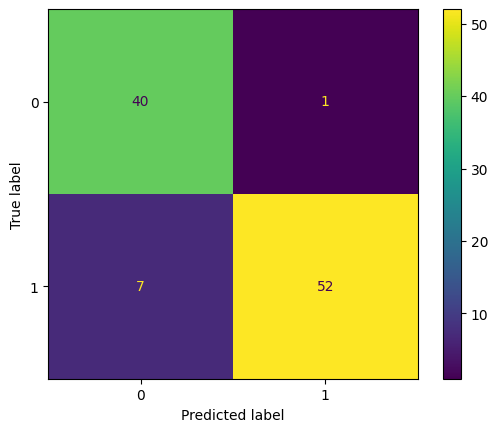

In [53]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix, accuracy_score

y_true = test_set_total["label"]
y_pred = test_set_total["pred_label"]

#confusion_matrix(y_true, y_pred)

## For a better display

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")


## Batching API Calls: ChatGPT (Few Shot)

In [ ]:
test_set.shape

(488, 3)

In [ ]:
test_set_total = test_set.sample(100)

test_set_total['pred_label'] = ''

test_set_total

,review,label,clean_reviews,pred_label
1267,I switched to google. The amazon helper is mor...,0,switched to google the amazon helper is more f...,
631,Eh. It’s works on and off. Half the time it do...,0,eh it works on and off half the time it does n...,
1742,I have been waiting for the Echo Show to go on...,1,have been waiting for the echo show to go on s...,
1563,It's like having another kid in the house; I h...,0,it like having another kid in the house have t...,
1517,Love my echo show! Great sound and picture. Do...,1,love my echo show great sound and picture does...,
...,...,...,...,...
2560,Love the echo dot it’s amaxing!!!,1,love the echo dot it amaxing,
2013,I bought this for myself and i didn’t realize ...,0,bought this for myself and didn realize it had...,
2520,Best purchase this year.,1,best purchase this year,
1200,Meh,0,meh,


In [ ]:
batches = []
batch_size = 50

for i in range(0, len(test_set_total), batch_size):
  batches.append(test_set_total[i : i + batch_size])  # Append batches instead of assigning

In [ ]:
import time

def gpt_completion_function(batch,current_batch,total_batch,train_sample,model="gpt-3.5-turbo-1106"):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing the Gemini Prompt
  # Step-3: Calling GPT API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_reviews','pred_label']].to_json(orient='records')

  sample_json_data = train_sample[['clean_reviews','label']].to_json(orient='records')

  prompt = f"""You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).
  Examples of good Sentiment Analysis Classification are provided between separator ####.
  These examples are for your reference, not to be included in your final output.

  ```
  {json_data}
  ```
  ####
  {sample_json_data}
  ####
  """

  print(prompt)

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)
  time.sleep(5)
  return response.choices[0].message["content"]

In [ ]:
train_sample = train_set.sample(4)

batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gpt_completion_function(batches[i],i,batch_count,train_sample))

Now processing batch#: 1 of 2
You are an expert linguist, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).
  Examples of good Sentiment Analysis Classification are provided between separator ####.
  These examples are for your reference, not to be included in your final output.

  ```
  [{"clean_reviews":"switched to google the amazon helper is more for shopping and google is the tasks assistant","pred_label":""},{"clean_reviews":"eh it work

In [ ]:
import json

df_total = pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Append the DataFrame to the final DataFrame
  df_total = df_total.append(df_temp, ignore_index=True)

print(df_total)  # Display the final DataFrame

                                        clean_reviews  pred_label
0   switched to google the amazon helper is more f...           0
1   eh it works on and off half the time it does n...           0
2   have been waiting for the echo show to go on s...           1
3   it like having another kid in the house have t...           0
4   love my echo show great sound and picture does...           1
..                                                ...         ...
95                       love the echo dot it amaxing           1
96  bought this for myself and didn realize it had...           0
97                            best purchase this year           1
98                                                meh           0
99  so far so good much better sound than my echo dot           1

[100 rows x 2 columns]


<ipython-input-85-6f10fdd72bc6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_temp, ignore_index=True)
<ipython-input-85-6f10fdd72bc6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_temp, ignore_index=True)


In [ ]:
# prompt: Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_total['pred_label'] = df_total['pred_label'].values
test_set_total

,review,label,clean_reviews,pred_label
1267,I switched to google. The amazon helper is mor...,0,switched to google the amazon helper is more f...,0
631,Eh. It’s works on and off. Half the time it do...,0,eh it works on and off half the time it does n...,0
1742,I have been waiting for the Echo Show to go on...,1,have been waiting for the echo show to go on s...,1
1563,It's like having another kid in the house; I h...,0,it like having another kid in the house have t...,0
1517,Love my echo show! Great sound and picture. Do...,1,love my echo show great sound and picture does...,1
...,...,...,...,...
2560,Love the echo dot it’s amaxing!!!,1,love the echo dot it amaxing,1
2013,I bought this for myself and i didn’t realize ...,0,bought this for myself and didn realize it had...,0
2520,Best purchase this year.,1,best purchase this year,1
1200,Meh,0,meh,0


In [ ]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix, accuracy_score

y_true = test_set_total["label"]
y_pred = test_set_total["pred_label"]

print(confusion_matrix(y_true, y_pred))
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")

[[49  0]
 [ 9 42]]

Accuracy: 0.91
